# History Git

## Importando Módulos

In [20]:
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from collections import Counter
import matplotlib.dates as mdates
from datetime import date
import matplotlib as mpl
import kaggle
import os

## Problema de Gestão de Código: Avaliar Commits

Questões a serem respondidas:

* Quais a incidências de insert / delete / arquivos alterados por commit?
* Quais o comportamento de commits por release ?
* Quais a relação de commits versus incidentes ?
* Quais métricas devemos usar para medir melhorias de processo ? 
* Quais o comportamento do dataset para os métodos Kmeans / DBSCAN ? 

## Dados

Campo   | Descrição
--------- | ------
 commit | mensagem do commit completa
 fchanged | nº de arquivos modificados       
 linsertion | nº de linhas inseridas
 ldeletion | nº de linhas removidas
 message | mensagem do commit
 user | usuário do commit
 date | data / hora do commit
 ldiff | nº linhas inseridas - nº linhas removidas  

## Pré processamento

### Gerando log de alterações
```
git log --since="2019-10-11" --no-merges --oneline --shortstat > git_changes.csv
git log --since="2019-10-11" --no-merges --date=local --pretty=format:"%h; %an; %cd" > git_by_date.csv
git log --since="2019-10-11" --no-merges --oneline --numstat > git_stats.txt

git log --since="2019-10-11" --merges --oneline --shortstat > git_changes.csv
git log --since="2019-10-11" --merges --date=local --pretty=format:'%h; %an; %ad' > git_by_date.csv
git log --pretty=format: --name-only | sort | uniq -c | sort -rg | head -10

```

## Script Geração de Dados Git

In [21]:
repo_path = "D:\HY\\VivoHybris"

current_path = os.getcwd()
#os.chdir(repo_path)
########################################
# Gerando arquivos estatisticas GIT 
########################################
os.system("git -C D:\\HY\\VivoHybris log --since=\"2019-10-11\" --no-merges --oneline --shortstat > ..\datasets\git_changes.csv")
os.system("git -C D:\\HY\\VivoHybris log --since=\"2019-10-11\" --no-merges --date=local --pretty=format:\"%h; %an; %cd\" > ..\datasets\git_by_date.csv")
os.system("git -C D:\\HY\\VivoHybris log --since=\"2019-10-11\" --no-merges --oneline --numstat > ..\datasets\git_stats.txt")

0

In [22]:
dirname = os.path.abspath('')
arquivo_in=dirname + '/../datasets/git_changes.csv'
arquivo_date_in=dirname + '/../datasets/git_by_date.csv'
arquivo_stats_in=dirname + '/../datasets/git_stats.txt'
arquivo_out=dirname + '/../datasets/git_changes_norm.csv'

########################################
# Transformando arquivos GIT git_changes
########################################
df_changes=pd.read_csv(arquivo_in,names=['data'],sep="|")
def extract_hash(data):
    match = re.search(r'(^[\S]{9})', data)
    if data.startswith(" "):
        return pd.NA
    else:
      return match.group(1)

df_changes['hash'] = df_changes['data'].apply(extract_hash)
df_changes['hash'].ffill(inplace=True)

df_changes['linsertion'] = df_changes['data'].str.extract('([\d]{1,} insertion)')
df_changes['ldeletion'] = df_changes['data'].str.extract('([\d]{1,} file)')
df_changes['fchanged'] = df_changes['data'].str.extract('([\d]{1,} deletion)')

df_changes['linsertion'] = df_changes['linsertion'].str.extract('([\d]{1,})')
df_changes['ldeletion'] = df_changes['ldeletion'].str.extract('([\d]{1,})')
df_changes['fchanged'] = df_changes['fchanged'].str.extract('([\d]{1,})')

df_changes['linsertion'] = pd.to_numeric(df_changes['linsertion'])
df_changes['ldeletion'] = pd.to_numeric(df_changes['ldeletion'])
df_changes['fchanged'] = pd.to_numeric(df_changes['fchanged'])

df_changes.fillna(0,inplace=True)

df_changes['ldiff'] = df_changes['linsertion'] - df_changes['ldeletion']

df_changes_minor = df_changes[df_changes['data'].str.contains("#minor")]
df_changes = df_changes[df_changes['data'].str.startswith(" ")]

df_changes.set_index("hash", inplace=True)
df_changes_minor.set_index("hash", inplace=True)

########################################
# Transformando arquivos GIT git_changes
########################################


In [24]:
df_changes

df_changes.to_csv('../datasets/df_changes.csv')  
df_date.to_csv('../datasets/df_date.csv')

## Análise Exploratória

In [23]:
########################################
# Git Log By Date
########################################

colnames_date=['hash','user','date'] 
df_date=pd.read_csv(arquivo_date_in,names=colnames_date,sep=';')
df_date.set_index("hash", inplace=True)
df_date['date'] = pd.to_datetime(df_date['date'], format=' %a %b %d %H:%M:%S %Y')
df_date['monthdate'] = df_date['date'].dt.to_period('M')

df_full = df_changes.join(df_date)

df_changes_minor = df_changes_minor.join(df_date)

########################################
# Git Log Stats
########################################
columns_stats = ['insert', 'delete','file_name']
df_stats = pd.read_csv(arquivo_stats_in, names=columns_stats,sep='\t')

df_stats = df_stats[~df_stats['file_name'].isna()]
df_stats = df_stats[df_stats['insert'] != "-"]
df_stats = df_stats[df_stats['delete'] != "-"]
df_stats['insert'] = pd.to_numeric(df_stats['insert'])
df_stats['delete'] = pd.to_numeric(df_stats['delete'])
df_stats_group = df_stats.groupby('file_name', as_index=False).sum()

df_stats_group = df_stats_group[(df_stats_group["file_name"].str.contains(".java"))]

########################################
# Removing outliers
########################################
df_full = df_full[(df_full['linsertion'] < 20)]
df_full = df_full[(df_full['ldeletion'] < 20)]
df_full = df_full[(df_full['fchanged'] < 20)]

df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2983 entries, 6ee5ba94d to 72508333e
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   data        2983 non-null   object        
 1   linsertion  2983 non-null   float64       
 2   ldeletion   2983 non-null   float64       
 3   fchanged    2983 non-null   float64       
 4   ldiff       2983 non-null   float64       
 5   user        2983 non-null   object        
 6   date        2983 non-null   datetime64[ns]
 7   monthdate   2983 non-null   period[M]     
dtypes: datetime64[ns](1), float64(4), object(2), period[M](1)
memory usage: 209.7+ KB


In [ ]:
df_full.describe()

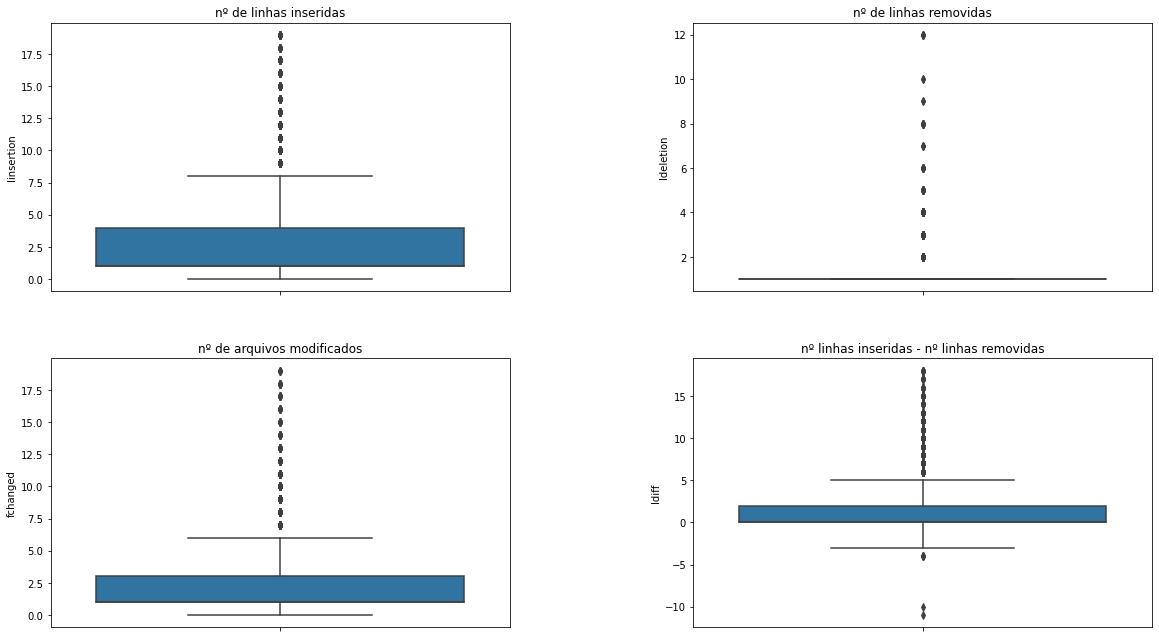

In [17]:
features = ['linsertion','ldeletion','fchanged','ldiff']
labels =  ['nº de linhas inseridas','nº de linhas removidas','nº de arquivos modificados','nº linhas inseridas - nº linhas removidas']

def plot_boxplot_features(features,labels):
    fig,axs=plt.subplots(nrows=2, ncols=2, figsize=(18,10))
    for col, ax, label in zip(features[0:], axs.ravel(),labels):
        x=df_full.loc[:, col]
        p = sns.boxplot(y=x, ax=ax, orient="v")
        ax.set_title(label)
        plt.subplots_adjust(top=0.92,bottom=0.08, left=0.10,right=0.95,hspace=0.25,wspace=0.4)

plot_boxplot_features(features,labels)

In [ ]:
np.arange(1,11)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


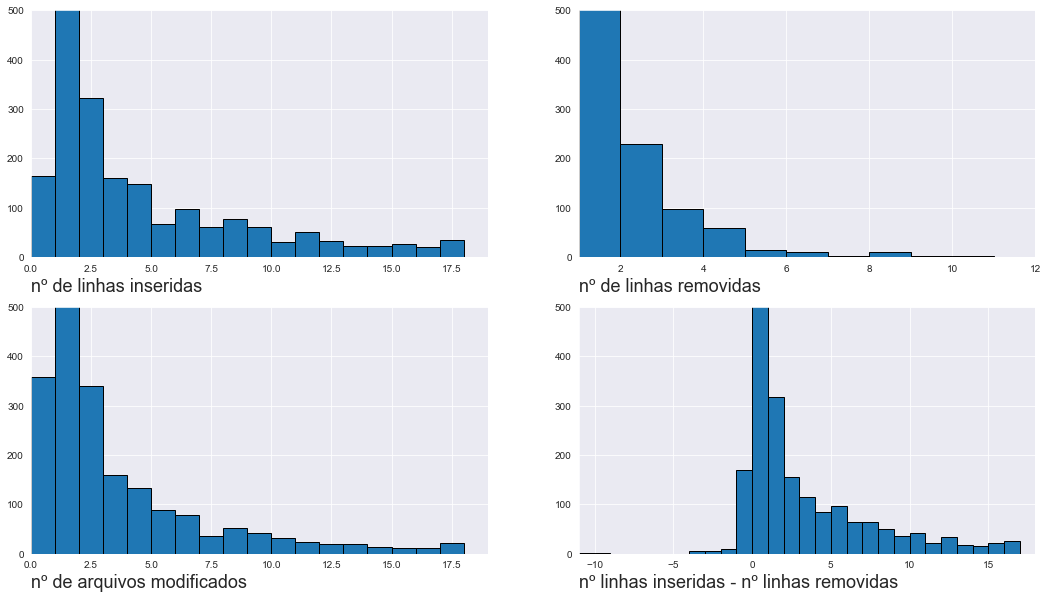

In [25]:
########################################
# Selecionar as variáveis quantitativas
########################################
features = ['linsertion','ldeletion','fchanged','ldiff']
labels =  ['nº de linhas inseridas','nº de linhas removidas','nº de arquivos modificados','nº linhas inseridas - nº linhas removidas']

def plot_features(features,labels):
    sns.set_style("darkgrid")
    fig,axs=plt.subplots(nrows=2, ncols=2, figsize=(18,10))
    for col, ax, label in zip(features[0:], axs.ravel(),labels):
        x=df_full.loc[:, col]
        #p = sns.distplot(x, ax=ax, color="blue", kde=False, hist_kws={'edgecolor':'black', 'alpha':1.0})
        p = sns.distplot(x, ax=ax, kde=False, bins=np.arange(x.min(),x.max()), hist_kws={'edgecolor':'black', 'alpha':1.0})
        p.set_xlabel(label, fontsize = "18", loc='left')
        ax.set_xlim(x.min(),x.max())
        ax.set_ylim(0,500)
        plt.grid()
        #plt.subplots_adjust(top=0.92,bottom=0.08, left=0.10,right=0.95,hspace=0.25,wspace=0.4)
########################################
# Análise exploratória dos dados usando o gráfico histograma
########################################
plot_features(features,labels)


## Filtrando Dados / Análise

In [ ]:
def plot_git_graph(df_full_filter):
    fig, axs = plt.subplots(3,figsize=(16,16), dpi=100)

    axs[0].scatter(df_full_filter['date'], df_full_filter['linsertion'], color='tab:red', label="insertion")
    axs[0].scatter(df_full_filter['date'], df_full_filter['ldeletion'], color='tab:blue', label="deletion")

    axs[1].scatter(df_full_filter['date'], df_full_filter['ldiff'], label="Diff")

    axs[2].scatter(df_full_filter['date'], df_full_filter['fchanged'], label="files changed")

    #axs[3].scatter(df_full_filter['date_day'], df_full_filter['linsertion'], color='tab:red', label="insertion")
    #axs[3].scatter(df_full_filter['date_day'], df_full_filter['ldeletion'], color='tab:blue', label="deletion")
    #axs[3].scatter(df_full_filter['date_day'], df_full_filter['ldiff'], color='tab:green', label="diff")

    axs[0].set(title='Insertion / Deletion Plot by date', ylabel='lines')
    axs[1].set(title='Delta (Insertion - Deletion) by date', ylabel='delta')
    axs[2].set(title='fchanged by date',  ylabel='qtd')
    #axs[3].set(title='Insertion / Deletion Scatter by date',  ylabel='qtd')

    axs[0].legend(loc='upper left')
    axs[1].legend(loc='upper left')
    axs[2].legend(loc='upper left')
    #axs[3].legend(loc='upper left')


In [ ]:
df_full_filter =df_full[(df_full['linsertion'] < 50) & (df_full['ldeletion'] < 50)]
plot_git_graph(df_full_filter)

In [ ]:
df_full['date_day'] = pd.to_datetime(df_full['date']).dt.floor('d')
df_changes_minor['date_day'] = pd.to_datetime(df_changes_minor['date']).dt.floor('d')
df_full_group = df_full.groupby('date_day', as_index=False).sum()

In [ ]:
def plot_insert_deletion(df_filter):
    fig, axs = plt.subplots(3,figsize=(16,16), dpi=100)
    axs[0].plot(df_filter['date_day'], df_filter['linsertion'], color='tab:blue', label="insertion")
    axs[0].plot(df_filter['date_day'], df_filter['ldeletion'], color='tab:red', label="deletion")
    axs[1].plot(df_filter['date_day'], df_filter['ldiff'], color='tab:green', label="diff")
    
    df_changes_minor["timeline"] = 0

    axs[1].scatter(df_changes_minor['date_day'], df_changes_minor['timeline'], color='tab:purple', label="minor")

    axs[2].plot(df_filter['date_day'], df_filter['ldeletion'], color='tab:red', label="deletion")
    axs[2].scatter(df_changes_minor['date_day'], df_changes_minor['timeline'], color='tab:purple', label="minor")

    axs[0].legend(loc='upper left')
    axs[1].legend(loc='upper left')
    axs[2].legend(loc='upper left')

    fig.suptitle('Git History by date')

def plot_scatter_insert_deletion(df_filter):
    plt.figure(figsize=(16,5), dpi=100)
    linsertion = plt.scatter(df_filter['date_day'], df_filter['linsertion'], color='tab:red')
    ldeletion = plt.scatter(df_filter['date_day'], df_filter['ldeletion'], color='tab:blue')
    ldiff = plt.scatter(df_filter['date_day'], df_filter['ldiff'], color='tab:green')
    plt.gca().set(title='Insertion / Deletion Scatter by date', xlabel='Date', ylabel='Value')
    plt.show()

df_filter =df_full_group[(df_full_group['linsertion'] < 50) & (df_full_group['ldeletion'] < 50)]
plot_insert_deletion(df_filter)
dates = df_full[df_full["data"].str.contains(" #minor")]["date_day"].ravel()
labels = df_full[df_full["data"].str.contains(" #minor")]["data"].ravel()


In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn import preprocessing

########################################
# KMeans
########################################
min_clusters = 1
max_clusters = 10

X = df_full[['fchanged', 'linsertion','ldeletion']]

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(x_scaled)

X.rename(columns={0:'fchanged', 1:'linsertion', 2:'ldeletion'},inplace=True)

wcss = []
for i in range(min_clusters, max_clusters):
  kmeans = KMeans(n_clusters=i)
  kmeans.fit(X)
  wcss.append(kmeans.inertia_)

plt.plot(range(min_clusters, max_clusters),wcss)
plt.show()

fig = plt.scatter(X.iloc[:,0],X.iloc[:,2])
fig = plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],s=150,marker= 'X', c='red')
plt.show()

########################################
# DBSCAN
########################################
modelo = DBSCAN(eps=0.1, min_samples=30, metric='euclidean').fit(X)

# Identificar os outliers 
outliers_df = X[modelo.labels_ == -1]
clusters_df = X[modelo.labels_ != -1]

colors = modelo.labels_
colors_clusters = colors[colors != -1]
colors_outliers = 'black'

clusters = Counter(modelo.labels_)
print('Número de clusters = {}'.format(len(clusters)-1))

fig = plt.figure()
ax = fig.add_axes([.1, .1, 1, 1])
ax.scatter(clusters_df['linsertion'], clusters_df['ldeletion'], c=colors_clusters, edgecolors='black', s=50)
ax.scatter(outliers_df['linsertion'], outliers_df['ldeletion'], c=colors_outliers, edgecolors='blue', s=50)
ax.set_xlabel('insertion', family = 'Arial', fontsize = 9)
ax.set_ylabel('deletion', family = 'Arial', fontsize = 9)

n_noise_ = list(modelo.labels_).count(-1)

plt.title('Clusters')
plt.grid(which='major', color='#cccccc', alpha=0.45)
print("Estimated number of noise points: %d" % n_noise_)

## SandBox

In [ ]:

# reference: https://mentalitch.com/key-events-in-rock-and-roll-history/
dates = [date(1954, 7, 19), date(1959, 2, 3), date(1964, 2, 9), date(1965, 7, 25), date(1967, 6, 1), date(1969, 8, 15)]
labels = ['Elvis appears on\nthe Ed Sullivan Show', 'Buddy Holly dies', 'The Beatles appear\non the Ed Sullivan Show', 
          'Bob Dylan goes electric', 'The Beatles release\nSgt. Pepper', 'Woodstock']

def timeline_relase(dates, labels):
    min_date = date(np.min(dates).year - 2, np.min(dates).month, np.min(dates).day)
    max_date = date(np.max(dates).year + 2, np.max(dates).month, np.max(dates).day)

    # labels with associated dates
    labels = ['{0:%d %b %Y}:\n{1}'.format(d, l) for l, d in zip (labels, dates)]
    fig, ax = plt.subplots(figsize=(16, 5), constrained_layout=True)
    _ = ax.set_ylim(-2, 1.75)
    _ = ax.set_xlim(min_date, max_date)
    _ = ax.axhline(0, xmin=0.05, xmax=0.95, c='deeppink', zorder=1)
    
    _ = ax.scatter(dates, np.zeros(len(dates)), s=120, c='palevioletred', zorder=2)
    _ = ax.scatter(dates, np.zeros(len(dates)), s=30, c='darkmagenta', zorder=3)

    label_offsets = np.zeros(len(dates))
    label_offsets[::2] = 0.35
    label_offsets[1::2] = -0.7
    for i, (l, d) in enumerate(zip(labels, dates)):
        _ = ax.text(d, label_offsets[i], l, ha='center', fontfamily='serif', fontweight='bold', color='royalblue',fontsize=12)

    stems = np.zeros(len(dates))
    stems[::2] = 0.3
    stems[1::2] = -0.3   
    markerline, stemline, baseline = ax.stem(dates, stems, use_line_collection=True)
    _ = plt.setp(markerline, marker=',', color='darkmagenta')
    _ = plt.setp(stemline, color='darkmagenta')

    # hide lines around chart
    for spine in ["left", "top", "right", "bottom"]:
        _ = ax.spines[spine].set_visible(False)
    
    # hide tick labels
    _ = ax.set_xticks([])
    _ = ax.set_yticks([])
    
    _ = ax.set_title('Important Milestones in Rock and Roll', fontweight="bold", fontfamily='serif', fontsize=16, 
                    color='royalblue')

timeline_relase(dates,labels)
# Prepare data
#df['year'] = [d.year for d in df.date]
#df['month'] = [d.strftime('%b') for d in df.date]
#years = df['year'].unique()

#df['value'] = df['Open']

# Prep Colors
#np.random.seed(100)
#mycolors = np.random.choice(mpl.colors.XKCD_COLORS.keys(), len(years), replace=False)

#df.loc[df.year==2011, 'value']

#df.loc[df.year==2011]
#print("##########################")
#print(df.loc[df.year==2011, :].shape[0]-.9)
#print(df.loc[df.year==2011, 'value'][-1:].values[0])
#print(df.loc[df.year==2011, :])
#print("##########################")
# Draw Plot
#plt.figure(figsize=(12,12), dpi= 80)
#for i, y in enumerate(years):
#    if i > 0:        
#        plt.plot('month', 'value', data=df.loc[df.year==y, :], color=mycolors[i], label=y)
#        plt.text(df.loc[df.year==y, :].shape[0]-.9, df.loc[df.year==y, 'value'][-1:].values[0], y, fontsize=5, color=mycolors[i])
#plt.plot('month', 'value', data=df.loc[df.year==2012, :], color=mycolors[0], label=2012)
#plt.plot('month', 'value', data=df.loc[df.year==2011, :], color=mycolors[1], label=2011)
#plt.plot('month', 'value', data=df.loc[df.year==2013, :], color=mycolors[2], label=2013)
#plt.plot('month', 'value', data=df.loc[df.year==2014, :], color=mycolors[3], label=2014)
#plt.plot('month', 'value', data=df.loc[df.year==2015, :], color=mycolors[3], label=2015)
#plt.plot('month', 'value', data=df.loc[df.year==2016, :], color=mycolors[3], label=2016)
#plt.plot('month', 'value', data=df.loc[df.year==2017, :], color=mycolors[3], label=2017)
#plt.plot('month', 'value', data=df.loc[df.year==2017, :], color=mycolors[3], label=2017)
#plt.text(df.loc[df.year==2011, :].shape[0]-.9, df.loc[df.year==2011, 'value'][-1:].values[0], 2011, fontsize=12, color=mycolors[0])

# Decoration
#plt.gca().set(xlim=(-0.3, 11), ylim=(2, 10000), ylabel='$Drug Sales$', xlabel='$Month$')
#plt.yticks(fontsize=12, alpha=.7)
#plt.title("Seasonal Plot of BitCoin", fontsize=20)
#plt.show()

#df_lower_period = df_lower_than_20[(df_lower_than_20['date']>pd.Timestamp(2019,11,20)) & (df_lower_than_20['date']<pd.Timestamp(2019,12,1))]  

#plt.figure(figsize=(16,5), dpi=100)
#linsertion = plt.scatter(df_lower_period['date'], df_lower_period['linsertion'], color='tab:red')
#ldeletion = plt.scatter(df_lower_period['date'], df_lower_period['ldeletion'], color='tab:blue')

#plt.legend((linsertion, ldeletion),
#           ('insertion', 'deletion'),
#           scatterpoints=1,
#           loc='upper right',
#           ncol=3,
#           fontsize=8)
#plt.gca().set(title='Insertion / Deletion Scatter by date', xlabel='Date', ylabel='Value')

#plt.show()

#def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
#    plt.figure(figsize=(16,5), dpi=dpi)
#    plt.plot(x, y, color='tab:red')
    
    #plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    #plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))

#    ax = plt.gca()

    # Major ticks every 6 months.
#    fmt_half_year = mdates.MonthLocator(interval=6)
#    ax.xaxis.set_major_locator(fmt_half_year)

    # Minor ticks every month.
#    fmt_month = mdates.MonthLocator()
#    ax.xaxis.set_minor_locator(fmt_month)

    # Text in the x axis will be displayed in 'YYYY-mm' format.
#    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    # Round to nearest years.
#    datemin = np.datetime64(df['date'][0], 'Y')
#    datemax = np.datetime64(df['date'].iloc[-1], 'Y') + np.timedelta64(1, 'Y')
    #ax.set_xlim(datemin, datemax)

    # Format the coords message box, i.e. the numbers displayed as the cursor moves
    # across the axes within the interactive GUI.
#    ax.format_xdata = mdates.DateFormatter('%Y-%m')
#    ax.format_ydata = lambda x: f'${x:.2f}'  # Format the price.
    #plt.gca().autofmt_xdate()

#    plt.gca().set(title=title, xlim=(0, 5000000), xlabel=xlabel, ylabel=ylabel)
    
#    plt.show()

#plot_df(df, x=df.index, y=df.Open, title='BITCOIN.')    

#ent1 = np.datetime64(df['date'][-1:].astype('object'), 'Y')
#ent2 = np.timedelta64(1, 'Y')
#entity = np.datetime64(df['date'][-1:], 'Y') + np.timedelta64(1, 'Y')
#print(type(ent1))
#print(type(1))
#print(df['date'].iloc[-1])
#print(entity)
#print( np.datetime64(df['date'][-1], 'Y') )

#plot_df(df, x=df.index, y=df.Weighted_Price, title='BITCOIN.')    


#df_timeline = df_full[df_full["message"] == " #minor"]

#plt.figure(figsize=(16,5), dpi=100)
#plt.scatter(df_timeline['date_day'], df_timeline['timeline'], color='tab:purple')

#def timeline_relase():
#    timeline_df = df_full[df_full["data"].str.contains("#minor")]
#    timeline_df["timeline"] = 0

#    plt.figure(figsize=(16,5), dpi=100)
    #plt.scatter(timeline_df['date_day'], df_filter['timeline'], color='tab:red')

    #plt.gca().set(title='Insertion / Deletion Scatter by date', xlabel='Date', ylabel='Value')
    #plt.show()

#################################################################################################################################################

#df_filter = df_filter[(df_filter['date_day']>pd.Timestamp(2019,1,1)) & (df_filter['date_day']<pd.Timestamp(2019,12,1))]  
#plot_scatter_insert_deletion(df_filter)
#dates = [date(1954, 7, 19), date(1959, 2, 3), date(1964, 2, 9), date(1965, 7, 25), date(1967, 6, 1), date(1969, 8, 15)]
#labels = ['Elvis appears on\nthe Ed Sullivan Show', 'Buddy Holly dies', 
#            'The Beatles appear\non the Ed Sullivan Show', 'Bob Dylan goes electric', 
#            'The Beatles release\nSgt. Pepper', 'Woodstock']

#timeline_relase()